In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from pyearth import Earth

In [50]:
warnings.filterwarnings("ignore")

In [11]:
train = pd.read_csv('data/train.csv')
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [12]:
test = pd.read_csv('data/test.csv')
test.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,5380,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,...,0.0380,0.0010,90204869909,0.26,8.0,5,5.0,30.1213,27.95,-0.49
1,5381,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,...,0.1866,0.0192,37449565014,0.02,16.0,1,8.0,2.1282,10.18,0.55
2,5382,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,...,0.0100,0.0017,10847937619,0.83,35.0,1,19.0,7.8513,21.27,19.09
3,5383,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,...,0.4636,0.0000,37200096,0.51,1.0,4,0.0,9.0511,18.38,4.11
4,5384,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,...,2.8737,0.0001,16400000000000,0.12,2.0,1,2.0,2.6512,149.68,0.02


In [13]:
train = train.fillna(0)
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

## Var Selection

In [14]:
corr = abs(X_train.corrwith(y_train))
corr[corr.isnull()==True]

x063   NaN
x137   NaN
x255   NaN
x385   NaN
x405   NaN
x453   NaN
x465   NaN
x518   NaN
x594   NaN
x643   NaN
x703   NaN
dtype: float64

In [15]:
X_train = X_train.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
X_test = test.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)

## PCA

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [19]:
pca = PCA(0.99)
pca.fit(X_train)

PCA(n_components=0.99)

In [20]:
X_train = pca.transform(X_train)
X_train.shape

(5380, 226)

In [21]:
col_id = test['id']
X_test = X_test.drop(['id'], axis = 1)
X_test = X_test.fillna(0)
X_test = scaler.transform(X_test)

In [22]:
X_test = pca.transform(X_test)
X_test.shape

(4403, 226)

## AdaBoost

>3 11.763 (0.605)
>4 11.602 (0.499)
>5 11.681 (0.457)
>6 11.734 (0.492)
>7 11.599 (0.504)
>8 11.679 (0.445)
>9 11.635 (0.433)
>10 11.757 (0.371)
>11 11.870 (0.273)
>12 11.949 (0.377)
>13 11.947 (0.339)
>14 12.110 (0.357)


Text(0.5, 0, 'Number of trees')

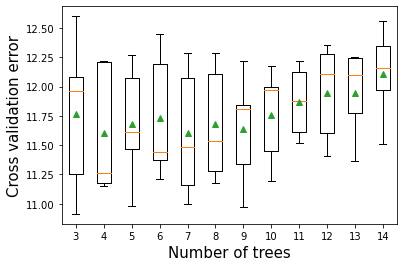

In [25]:
def get_models():
    models = dict()
    for n in range(3, 15):
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

In [26]:
def get_models():
    models = dict()
    for i in range(1,13):
        base = DecisionTreeRegressor(max_depth=i)
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
# plot    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>1 12.877 (0.919)
>2 13.831 (1.078)
>3 13.911 (0.740)
>4 12.714 (0.980)
>5 11.777 (1.115)


KeyboardInterrupt: 

In [27]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [4, 7]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -125.380405 using {'base_estimator': DecisionTreeRegressor(max_depth=5), 'n_estimators': 7}


In [29]:
model_ADA = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=7,
                              random_state=1).fit(X_train, y_train)

## RF

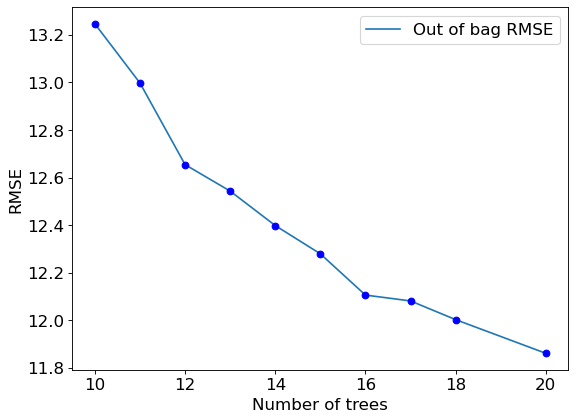

In [30]:
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}
for i in np.linspace(10, 20, 10,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(X_train, y_train)
    oob_rsquared[i]=model.oob_score_  
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y_train))
    
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

Text(0, 0.5, 'Classification accuracy')

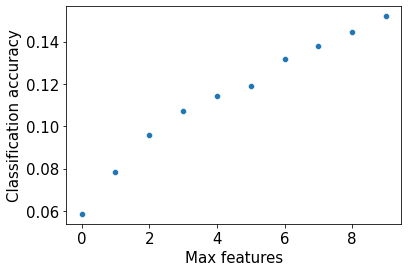

In [31]:
oob_score = {}

i=0
for pr in range(1, 11):
    model = RandomForestRegressor(random_state=1, oob_score=True, verbose=False, n_estimators = 500,
                                  max_features=pr, n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
sns.scatterplot(x = oob_score.keys(), y = oob_score.values())
plt.xlabel('Max features')
plt.ylabel('Classification accuracy')

In [35]:
params = {'n_estimators': [12],
          'max_features': [1,2]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (12, 2)
Best score (R-squared) =  -0.19069353520129173


In [36]:
model_RF = RandomForestRegressor(n_estimators=12, max_features=2, random_state=1, n_jobs=-1).fit(X_train, y_train)

## XGBoost

>3 11.417 (0.668)
>4 11.086 (0.681)
>5 10.953 (0.657)
>6 10.834 (0.607)
>7 10.807 (0.538)
>8 10.771 (0.515)
>9 10.741 (0.510)


Text(0.5, 0, 'Number of trees')

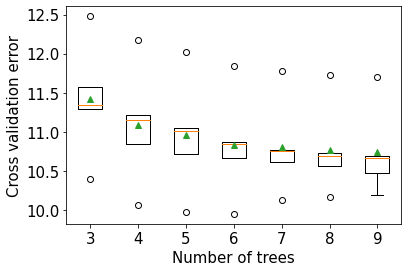

In [37]:
def get_models():
    models = dict()
    n_trees = [3, 4, 5, 6, 7, 8, 9]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

In [38]:
def get_models():
    models = dict()
    for i in range(1,13,2):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>1 10.235 (1.388)
>3 10.345 (1.202)
>5 10.573 (1.203)
>7 10.623 (1.161)


KeyboardInterrupt: 

In [39]:
def get_models():
    models = dict()
    for i in [0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0100 11.2 (1.6)
>0.0150 10.8 (1.5)
>0.0200 10.6 (1.4)


KeyboardInterrupt: 

>0.0100 11.2 (1.1)
>0.0500 10.9 (1.1)
>0.1000 10.9 (1.0)
>0.2500 11.0 (1.2)
>0.5000 10.8 (1.3)
>1.0000 10.6 (1.2)


Text(0.5, 0, 'reg_lambda')

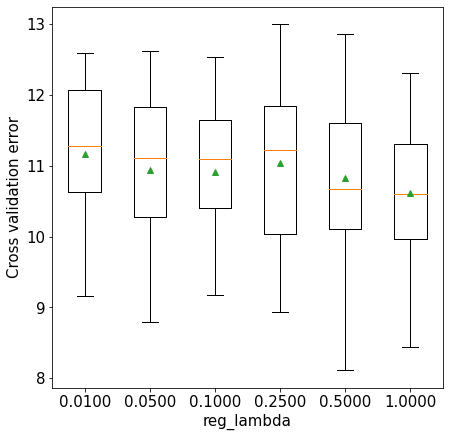

In [40]:
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [30]:
param_grid = {'n_estimators':[4],
              'max_depth': [2, 3, 4, 5],
              'learning_rate': [0.10, 0.125, 0.15],
              'reg_lambda':[]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train , y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Optimal parameter values = {'learning_rate': 0.14, 'max_depth': 5, 'n_estimators': 4, 'reg_lambda': 0.1}
Optimal cross validation R-squared =  0.00709032661470792


In [41]:
model_XG = xgb.XGBRegressor(random_state=1, max_depth=5, n_estimators=4, learning_rate = 0.14, reg_lambda=0.1).fit(X_train, y_train)

## MARS

In [48]:
model_MARS = Earth(max_terms = 400, max_degree = 1).fit(X_train, y_train)

## Ensemble

In [49]:
model_ensemble= StackingRegressor(estimators = [('ADA', model_ADA),
                                                ('RF', model_RF),
                                                ('XG', model_XG),
                                                ('MARS', model_MARS)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train, y_train)

KeyboardInterrupt: 

In [43]:
model_ensemble.final_estimator_.coef_

array([0.65643026, 0.18268759, 0.70572319])

In [44]:
pred12 = model_ensemble.predict(X_test)

pred_v12 = pd.DataFrame(index=range(X_test.shape[0]), columns=range(2))
pred_v12.columns = ['id', 'y']
pred_v12['id'] = col_id
pred_v12['y'] = pred12
pred_v12

,id,y
0,5380,7.128656
1,5381,8.290696
2,5382,5.749638
3,5383,5.816847
4,5384,20.323881
...,...,...
4398,9778,6.445186
4399,9779,7.562908
4400,9780,6.940541
4401,9781,24.368327


In [45]:
pred_v11.to_csv('pred_v11.csv', index=True)